In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter

height, width = 224, 224
batch_size=64

def generate_data(DIR):
  datagen = ImageDataGenerator(rescale=1./255.)
  generator = datagen.flow_from_directory(
  DIR,
  batch_size=batch_size,
  shuffle=True,
  seed=42,
  class_mode='categorical',
  target_size=(height, width),
  classes={'COVID19': 0, 'NORMAL': 1,'PNEUMONIA': 2}
  )
  return generator

TRAINING_DIR = '/content/drive/MyDrive/Data/train'
VALIDATION_DIR = '/content/drive/MyDrive/Data/test'


train_generator = generate_data(TRAINING_DIR)
validation_generator = generate_data(VALIDATION_DIR)


total_image = np.concatenate([train_generator.labels,validation_generator.labels])
print('\n\n',{'COVID19':len(np.where(total_image==0)[0]),
'NORMAL':len(np.where(total_image==1)[0]),
'PNEUMONIA':len(np.where(total_image==2)[0])})


Found 903 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


 {'COVID19': 417, 'NORMAL': 406, 'PNEUMONIA': 404}


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(train_generator)
print(validation_generator)

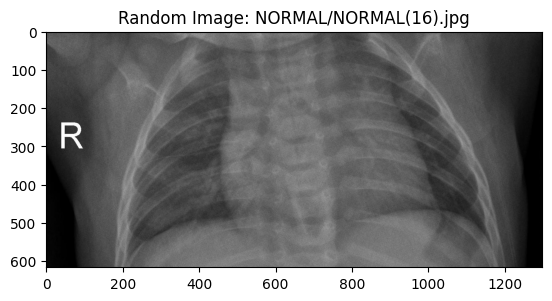

In [5]:
import cv2
import random

train_folder = '/content/drive/MyDrive/Data/train'

sub_folders = [folder for folder in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, folder))]
if len(sub_folders) > 0:
  random_sub_folder = random.choice(sub_folders)
  sub_folder_path = os.path.join(train_folder, random_sub_folder)
  # Get the list of image files in the selected sub-folder
  image_files = [file for file in os.listdir(sub_folder_path) if os.path.isfile(os.path.join(sub_folder_path, file))]
# Choose a random image file from the list for display
  if len(image_files) > 0:
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(sub_folder_path, random_image_file)
    # Read and display the random image
    random_image = cv2.cvtColor(cv2.imread(random_image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(random_image)
    plt.title(f"Random Image: {os.path.join(random_sub_folder,random_image_file)}")
    plt.show()
  else:
    print(f"No image files found in the {random_sub_folder} sub-folder.")
else:
  print("No sub-folders found in the train dataset.")

**Number of components needed to preserve 90% of the variance:** 75

In [7]:
print(image_data.shape)

(903, 4096)


In [8]:
image_data_scaled.shape

(903, 4096)

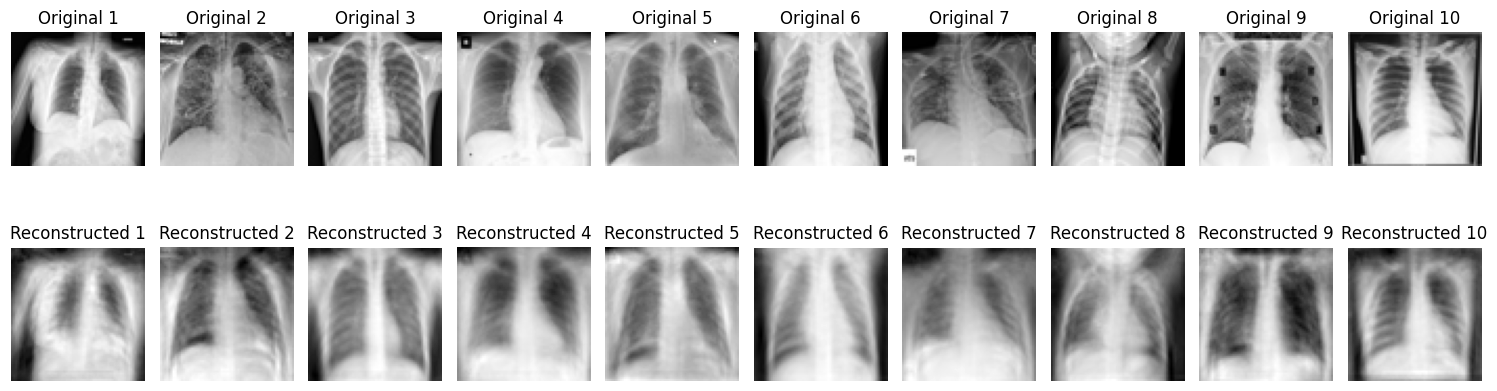

In [9]:
# Select 10 random images for plotting
random_indices = np.random.choice(image_data.shape[0], size=10, replace=False)

# Plot the original images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_data[idx].reshape(image_shape), cmap='gray')
    plt.axis('off')
    plt.title(f"Original {i + 1}")


pca_reduced = PCA(n_components=num_components_90)
image_data_reduced = pca_reduced.fit_transform(image_data_scaled)

# Reconstruct the images from the reduced data
reconstructed_images_scaled = pca_reduced.inverse_transform(image_data_reduced)

# Reverse the scaling of reconstructed images
reconstructed_images = scaler.inverse_transform(reconstructed_images_scaled)

# Plot the reconstructed images
for i, idx in enumerate(random_indices):
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(reconstructed_images[idx].reshape(image_shape), cmap='gray')
    plt.axis('off')
    plt.title(f"Reconstructed {i + 1}")

plt.tight_layout()
plt.show()


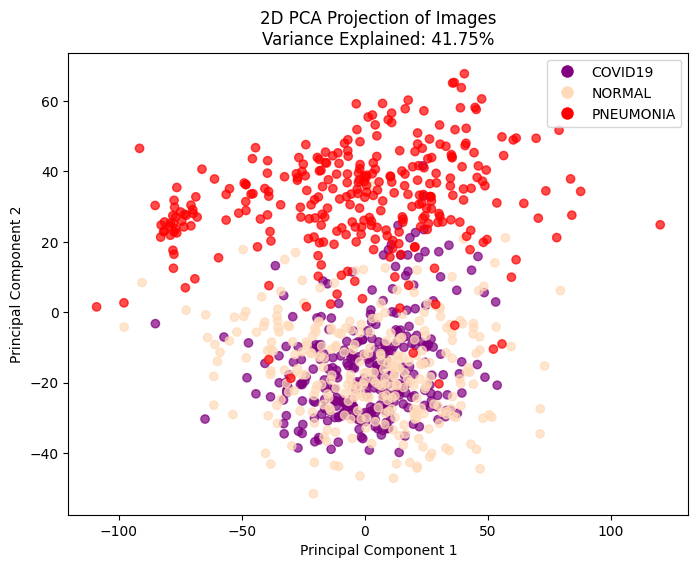

Variance explained by the first two principal components: 41.75%


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Step 1: Extract labels directly from folder names
folders = sorted(os.listdir(train_folder))  # Sorted to ensure consistent label mapping
folder_to_color = {folder: color for folder, color in zip(folders, ['purple', '#FFDAB9', 'red'])}

colors = [folder_to_color[folder] for folder in folders for _ in os.listdir(os.path.join(train_folder, folder))]

# Step 2: Perform PCA
pca_2d = PCA(n_components=2)
image_data_2d = pca_2d.fit_transform(image_data_scaled)  # Use scaled image data

variance_explained = np.sum(pca_2d.explained_variance_ratio_)

# Step 3: Plot 2D Projection
plt.figure(figsize=(8, 6))

# Scatter plot with corresponding colors
scatter = plt.scatter(image_data_2d[:, 0], image_data_2d[:, 1], c=colors, marker='o', alpha=0.7)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=folder)
    for folder, color in folder_to_color.items()
]

plt.legend(handles=legend_elements, loc='upper right')

# Titles and labels
plt.title(f'2D PCA Projection of Images\nVariance Explained: {variance_explained * 100:.2f}%')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print variance explained by the first two components
print(f'Variance explained by the first two principal components: {variance_explained * 100:.2f}%')


**Variance explained by the first two principal components:** 41.75%

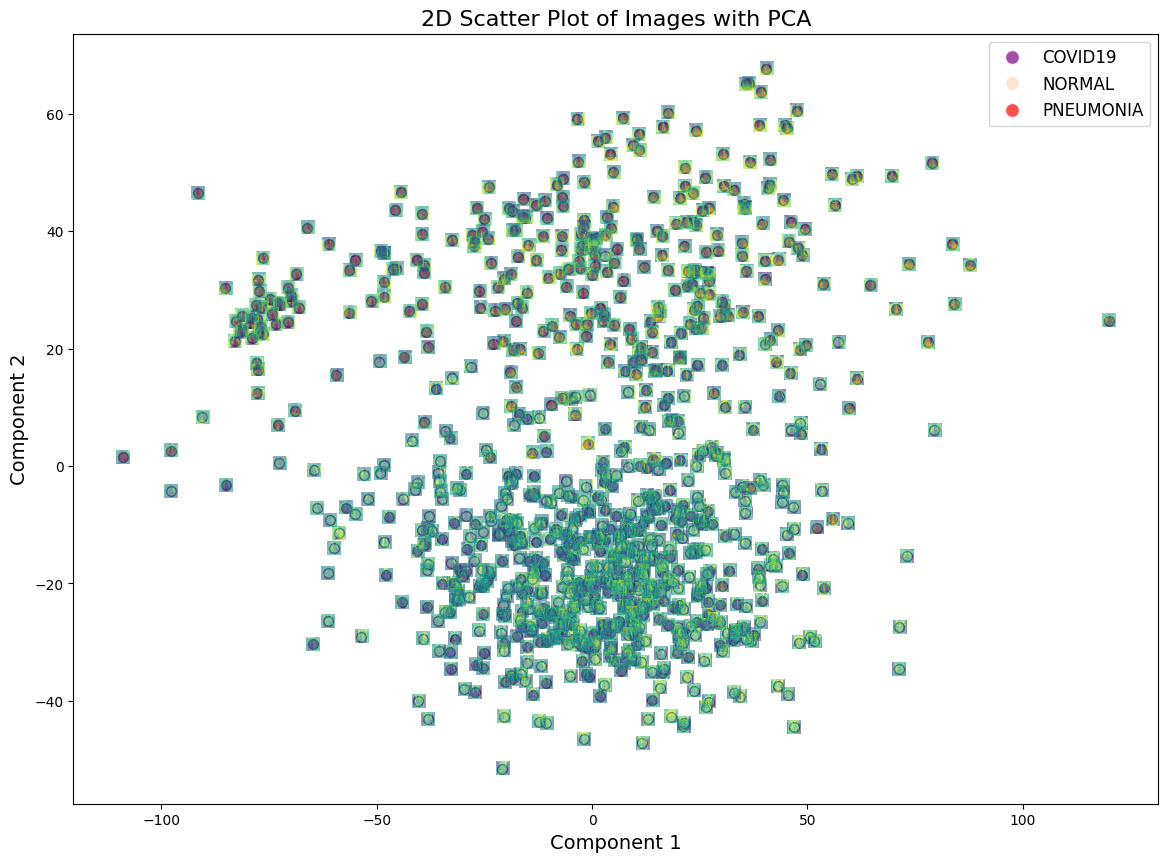

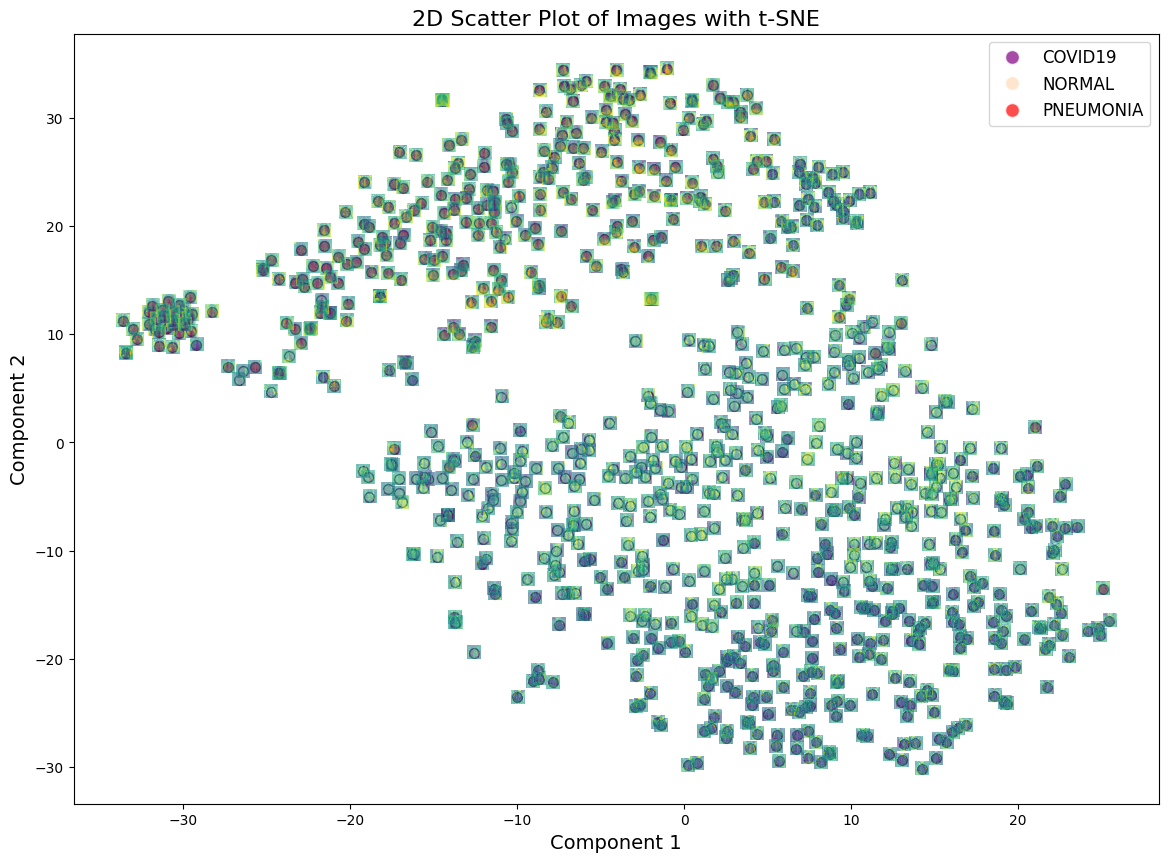

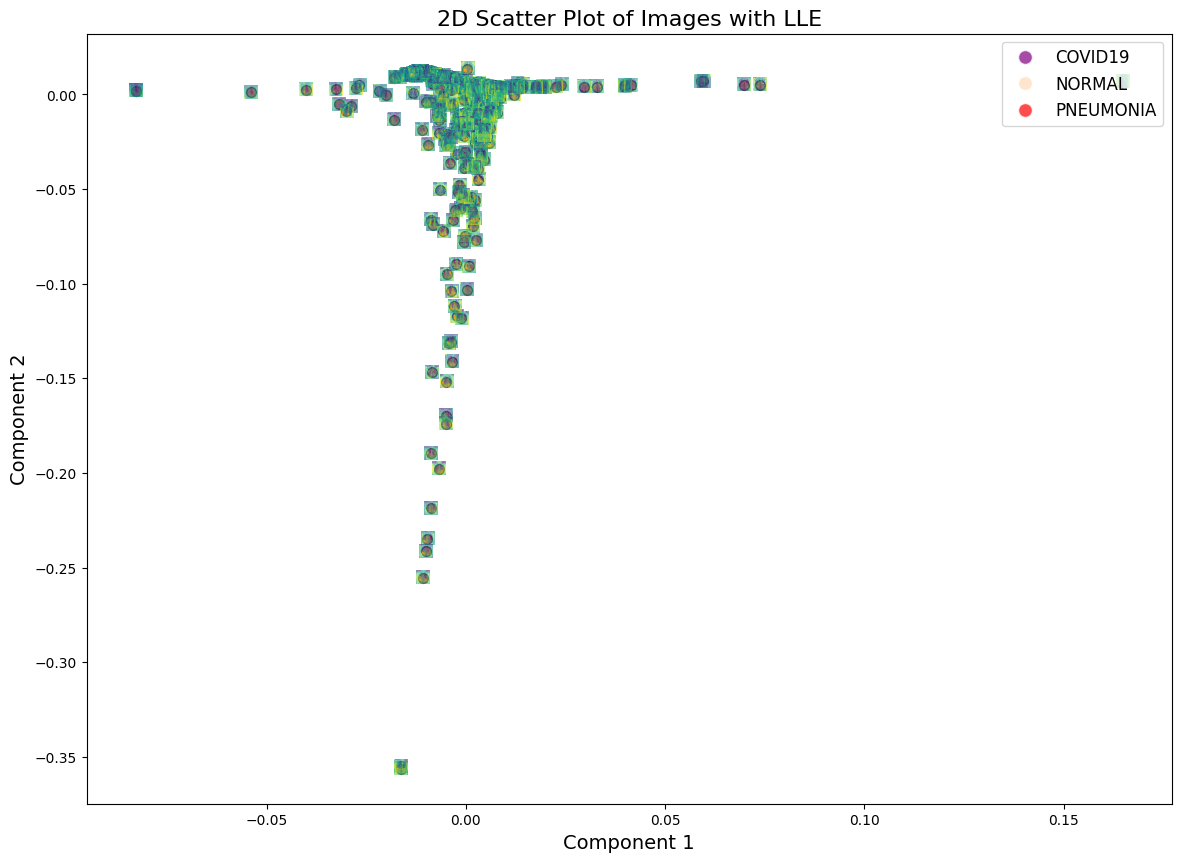

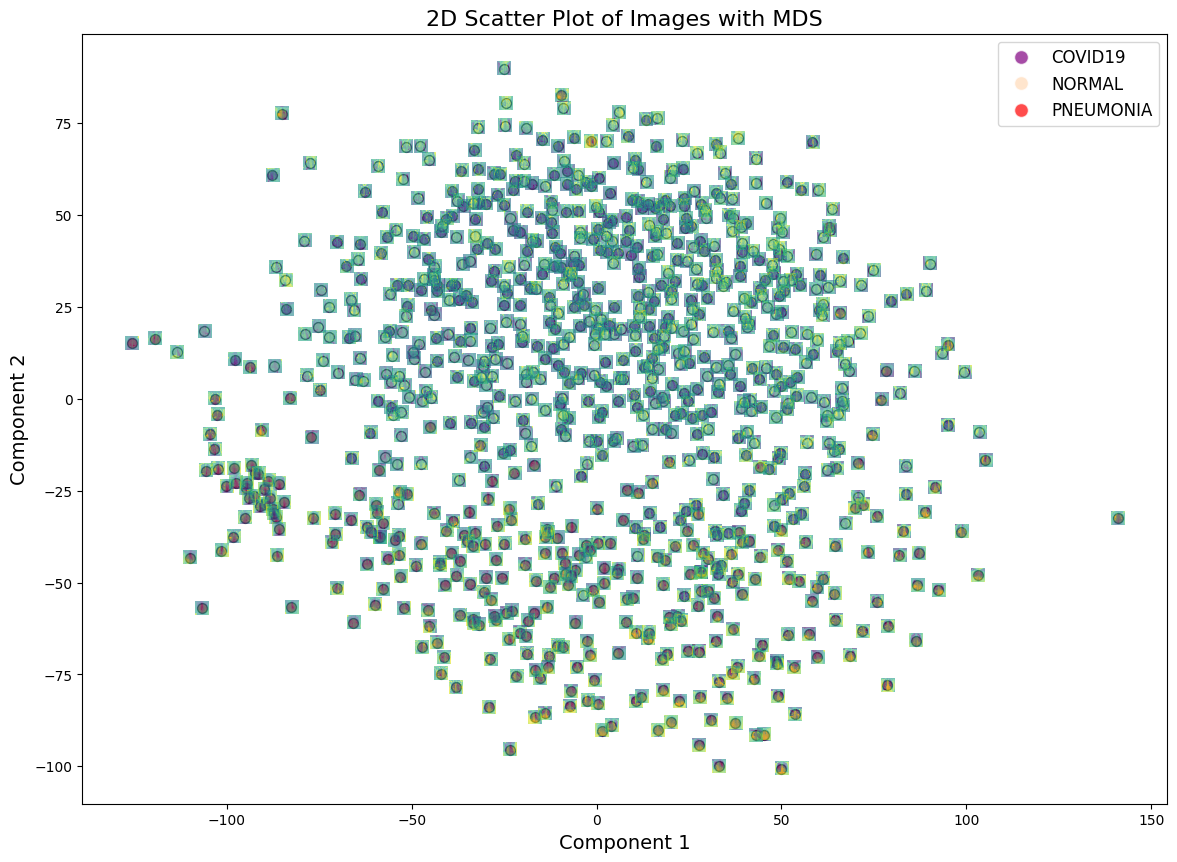

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Step 1: Extract folder names (categories) and create a color map
folders = sorted(os.listdir(train_folder))  
folder_to_color = {folder: color for folder, color in zip(folders, ['purple', '#FFDAB9', 'red'])}

colors = []
for folder in folders:
    num_images = len(os.listdir(os.path.join(train_folder, folder)))  # Count images in each folder
    colors.extend([folder_to_color[folder]] * num_images)

# Step 2: Define the plotting function
def plot_images(ax, data, images, colors, image_shape):
    for i, (x, y) in enumerate(data):
        ax.scatter(x, y, color=colors[i], marker='o', edgecolors='k', s=50, alpha=0.7)  # Marker size for clarity
        image = images[i].reshape(image_shape)
        imagebox = OffsetImage(image, zoom=0.15, alpha=0.6)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=folder,
                      markerfacecolor=color, markersize=10, alpha=0.7) for folder, color in folder_to_color.items()]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

def plot_dimensionality_reduction_individual(method, method_name, image_data_scaled, image_shape):
    if method_name == 'PCA':
        reduced_data = PCA(n_components=2).fit_transform(image_data_scaled)
    elif method_name == 't-SNE':
        reduced_data = TSNE(n_components=2, random_state=42).fit_transform(image_data_scaled)
    elif method_name == 'LLE':
        reduced_data = LocallyLinearEmbedding(n_components=2).fit_transform(image_data_scaled)
    elif method_name == 'MDS':
        reduced_data = MDS(n_components=2, random_state=42).fit_transform(image_data_scaled)

    fig, ax = plt.subplots(figsize=(14, 10))
    plot_images(ax, reduced_data, image_data_scaled, colors, image_shape)
    ax.set_title(f'2D Scatter Plot of Images with {method_name}', fontsize=16)
    ax.set_xlabel('Component 1', fontsize=14)
    ax.set_ylabel('Component 2', fontsize=14)
    plt.show()

# Step 3: Set image shape (adjust based on your dataset)
image_shape = (64, 64)  # Example: Adjust to your actual image dimensions

# Step 4: Apply and visualize different dimensionality reduction techniques
plot_dimensionality_reduction_individual(PCA, 'PCA', image_data_scaled, image_shape)
plot_dimensionality_reduction_individual(TSNE, 't-SNE', image_data_scaled, image_shape)
plot_dimensionality_reduction_individual(LocallyLinearEmbedding, 'LLE', image_data_scaled, image_shape)
plot_dimensionality_reduction_individual(MDS, 'MDS', image_data_scaled, image_shape)


# **Inference from the Graphs (Question 3 C:**


**1. PCA (Principal Component Analysis) Scatter Plot:**

**Clustering Observations:**
PCA reduces the dimensionality of the image data into two principal components (Component 1 and Component 2).
The data points appear scattered with no clear separation or clustering among the three classes (COVID-19, NORMAL, and PNEUMONIA).
Overlaps among the classes are significant, indicating that PCA is not effective in creating distinct clusters for these data types.

**Effectiveness:**
PCA is a linear dimensionality reduction technique and may not be suitable for datasets with nonlinear separability or complex relationships.
While it captures variance, it fails to separate classes clearly in this case, showing limited clustering effectiveness.

**2. t-SNE (t-Distributed Stochastic Neighbor Embedding) Scatter Plot:**

**Clustering Observations:**
t-SNE reduces dimensionality with a focus on preserving local relationships within the data.
The points form visually distinct clusters, with noticeable separation between classes (COVID-19, NORMAL, and PNEUMONIA), compared to the PCA plot.
While some overlaps exist, t-SNE shows a better separation, especially in capturing non-linear structures within the data.

**Effectiveness:**
t-SNE effectively identifies patterns and relationships in high-dimensional data by mapping them into a 2D space.
It is significantly better than PCA in clustering these classes, making it a more suitable technique for visualizing complex datasets like image embeddings.

**3. 2D Scatter Plot with LLE (Locally Linear Embedding)**

**Observation:**
The data points are tightly clustered along a narrow, elongated pattern.
There is minimal spread in both Component 1 and Component 2 dimensions.
A large portion of the points overlaps, with no clear distinction between different labels (COVID-19, NORMAL, and PNEUMONIA).

**Effectiveness for Clustering:**
The LLE technique struggles to separate the data meaningfully in 2D space.
While LLE is good for preserving local structures in high-dimensional data, here it fails to visually separate the clusters corresponding to the three categories.

**4. 2D Scatter Plot with MDS (Multidimensional Scaling)
Observation:**

The data points are more evenly spread across the plot, with a wider range of variation in both Component 1 and Component 2 dimensions.
However, there is still significant overlap between points of different labels (COVID-19, NORMAL, and PNEUMONIA).
Slight hints of clusters can be observed, but they are not well-separated.
Effectiveness for Clustering:

**Moderate effectiveness:**
MDS provides a more spread-out visualization compared to LLE, which can help distinguish between groups to some extent.
However, it does not produce clear separations between categories, which implies that the clusters still overlap significantly in the reduced space.

**Summary**

**PCA:** Poor at clustering the classes; it captures variance but does not handle non-linear separability effectively.

**t-SNE:** Provides a more meaningful clustering, preserving local structures and creating visually distinguishable groups. However, it is computationally intensive compared to PCA.

**LLE:** Preserves local distances but is ineffective in distinguishing between clusters. Data points are packed tightly along a narrow band.

**MDS:** Provides a more global view of data distribution with better separation but still lacks strong cluster distinction.


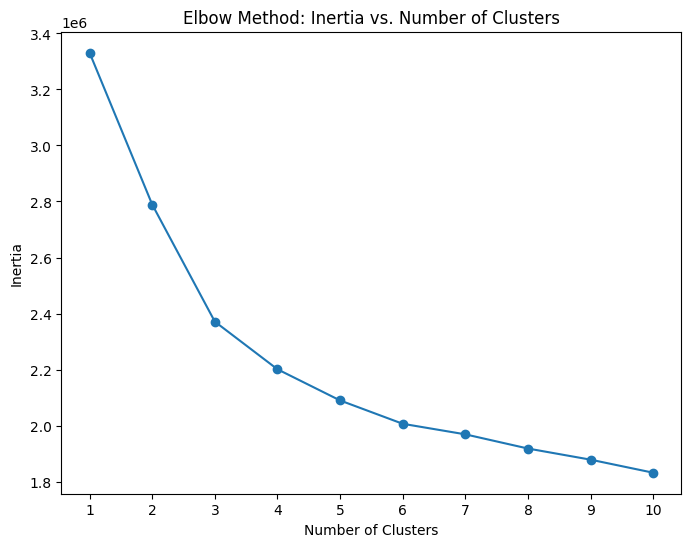

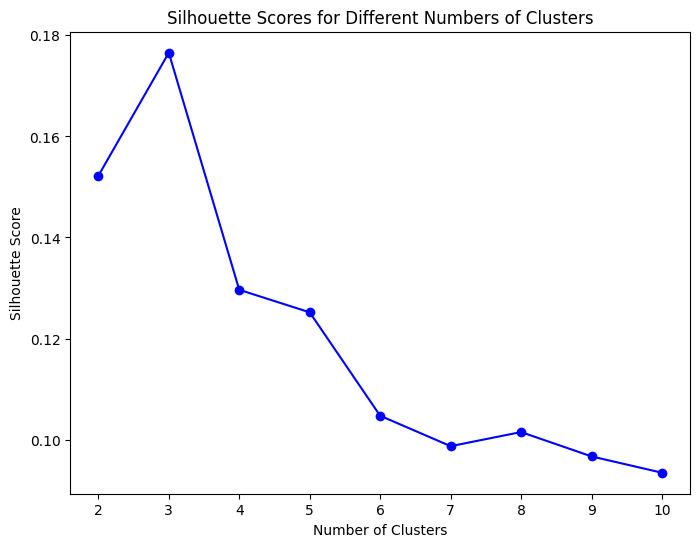

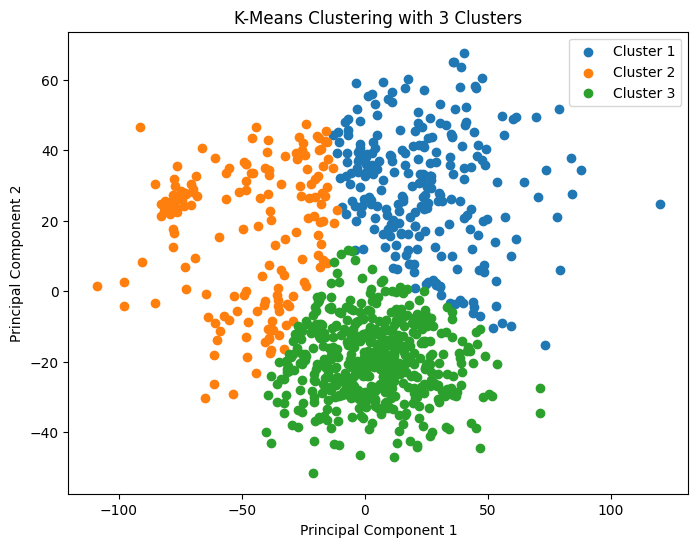

Number of images in each cluster: 
2    495
0    243
1    165
Name: count, dtype: int64


In [12]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

pca = PCA(n_components=0.9)  # Keep at least 90% of the variance
image_data_pca = pca.fit_transform(image_data_scaled)
# Step 2: Use the Elbow Method or Silhouette Analysis to determine the number of clusters
# Elbow Method
inertia = []
range_clusters = range(1, 11)  # Testing for 1 to 10 clusters
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(image_data_reduced)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_clusters)
plt.show()

# Step 3: Silhouette Analysis (alternative method to choose the number of clusters)
silhouette_scores = []
for n_clusters in range_clusters[1:]:  # Starting from 2 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(image_data_scaled)
    silhouette_avg = silhouette_score(image_data_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range_clusters[1:], silhouette_scores, marker='o', color='b')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# we plot using 3 clusters as specified
optimal_clusters = 3

# Step 5: Perform K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(image_data_pca)

image_data_with_labels = pd.DataFrame(image_data)
image_data_with_labels['Cluster'] = cluster_labels

# Step 6: Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(optimal_clusters):
    plt.scatter(image_data_pca[cluster_labels == i, 0], image_data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Print the number of images in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()
print(f"Number of images in each cluster: \n{cluster_counts}")


In [13]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os

folders = sorted(os.listdir(train_folder))  # Sorted for consistent ordering
label_encoder = LabelEncoder()

true_labels = []
for folder_index, folder_name in enumerate(folders):
    folder_path = os.path.join(train_folder, folder_name)
    num_images = len(os.listdir(folder_path))  # Count images in the folder
    true_labels.extend([folder_index] * num_images)  # Assign a label for all images in this folder

# Step 2: Compute clustering accuracy
def compute_accuracy(true_labels, cluster_labels):
    # Create a contingency matrix
    contingency_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(cluster_labels))))

    for true, cluster in zip(true_labels, cluster_labels):
        contingency_matrix[true, cluster] += 1

    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Calculate the accuracy
    accuracy = contingency_matrix[row_ind, col_ind].sum() / len(true_labels)
    return accuracy

# Calculate the accuracy
accuracy = compute_accuracy(true_labels, cluster_labels)

accuracy_percentage = accuracy * 100
print(f"K-Means Clustering Accuracy: {accuracy_percentage:.2f}%")


K-Means Clustering Accuracy: 53.82%


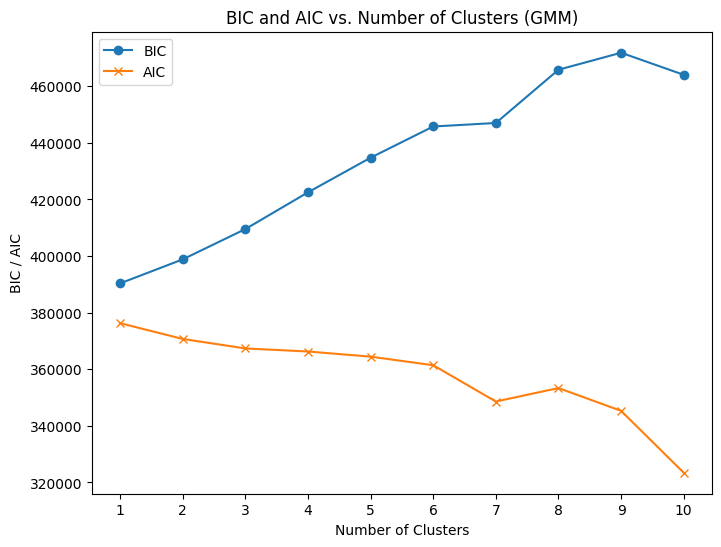

Optimal number of clusters based on BIC: 1
Optimal number of clusters based on AIC: 10


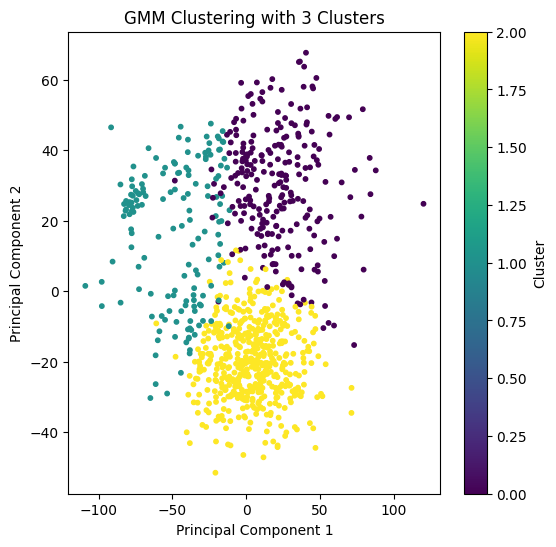

Number of images in the 3 clusters: 
2    500
0    248
1    155
Name: count, dtype: int64


In [36]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Perform PCA for dimensionality reduction
pca = PCA(n_components=0.9)  # Keep at least 90% of the variance
image_data_pca = pca.fit_transform(image_data_scaled)

# Step 2: Use BIC and AIC to determine the optimal number of clusters
bic = []
aic = []
range_clusters = range(1, 11)  # Testing for 1 to 10 clusters
for n_clusters in range_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(image_data_pca)
    bic.append(gmm.bic(image_data_pca))
    aic.append(gmm.aic(image_data_pca))

plt.figure(figsize=(8, 6))
plt.plot(range_clusters, bic, marker='o', label='BIC')
plt.plot(range_clusters, aic, marker='x', label='AIC')
plt.title('BIC and AIC vs. Number of Clusters (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC / AIC')
plt.legend()
plt.xticks(range_clusters)
plt.show()

# Step 3: Display the optimal number of clusters based on BIC and AIC
optimal_clusters_bic = range_clusters[np.argmin(bic)]  # BIC minimum
optimal_clusters_aic = range_clusters[np.argmin(aic)]  # AIC minimum

print(f"Optimal number of clusters based on BIC: {optimal_clusters_bic}")
print(f"Optimal number of clusters based on AIC: {optimal_clusters_aic}")

# Step 4: Perform GMM clustering with a fixed number of clusters (n_clusters = 1)
gmm_fixed = GaussianMixture(n_components=3, random_state=42)
cluster_labels_fixed = gmm_fixed.fit_predict(image_data_pca)

plt.figure(figsize=(6, 6))
plt.scatter(image_data_pca[:, 0], image_data_pca[:, 1], c=cluster_labels_fixed, cmap='viridis', s=10)
plt.title('GMM Clustering with 3 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 5: Print the number of images in the single cluster
cluster_counts_fixed = pd.Series(cluster_labels_fixed).value_counts()
print(f"Number of images in the 3 clusters: \n{cluster_counts_fixed}")


In [37]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
from sklearn.mixture import GaussianMixture

# Step 1: Map folder names to numerical labels (True Labels)
folders = sorted(os.listdir(train_folder))  # Sorted for consistent ordering
label_encoder = LabelEncoder()

true_labels = []
for folder_index, folder_name in enumerate(folders):
    folder_path = os.path.join(train_folder, folder_name)
    num_images = len(os.listdir(folder_path))  
    true_labels.extend([folder_index] * num_images)  

true_labels = np.array(true_labels)

# Step 2: Perform clustering with a fixed number of clusters: 3
gmm_fixed = GaussianMixture(n_components=3, random_state=42)
cluster_labels_fixed = gmm_fixed.fit_predict(image_data_pca)

# Step 3: Define a function to compute accuracy using the Hungarian algorithm
def compute_accuracy(true_labels, cluster_labels):
    contingency_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(cluster_labels))))
    for true, cluster in zip(true_labels, cluster_labels):
        contingency_matrix[true, cluster] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix) 
    accuracy = contingency_matrix[row_ind, col_ind].sum() / len(true_labels)
    return accuracy

# Step 4: Calculate and print accuracy for fixed clusters (n_clusters = 13
accuracy_fixed = compute_accuracy(true_labels, cluster_labels_fixed)
accuracy_fixed_percentage = accuracy_fixed * 100
print(f"GMM Clustering Accuracy (Fixed 3 cluster): {accuracy_fixed_percentage:.2f}%")


GMM Clustering Accuracy (Fixed 3 cluster): 55.48%


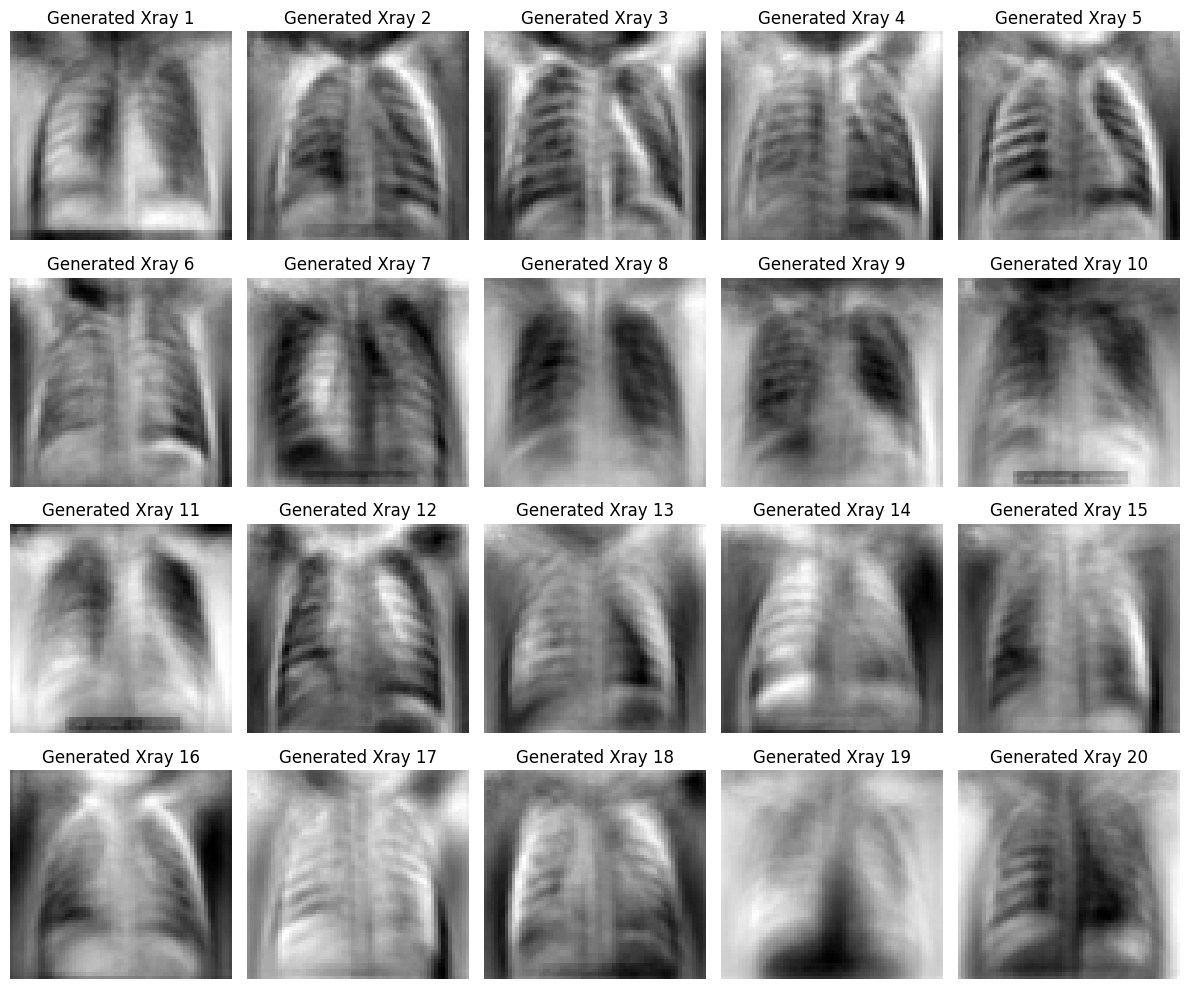

In [24]:
def generate_and_visualize_new_rocks(gmm, pca, n_samples=20,original_image_shape=(64, 64)):
# Generate samples from the GMM
  generated_samples, _ = gmm.sample(n_samples=n_samples)
  original_samples = pca.inverse_transform(generated_samples)
  # Visualize the generated images
  fig, axes = plt.subplots(4, 5, figsize=(12, 10))
  for i, ax in enumerate(axes.ravel()):
    # Reshape to match the original image dimensions
    ax.imshow(original_samples[i].reshape(original_image_shape), cmap='gray', aspect='auto')
    ax.axis('off')
    ax.set_title(f'Generated Xray {i+1}')
  plt.tight_layout()
  plt.show()

generate_and_visualize_new_rocks(gmm, pca, n_samples=20)

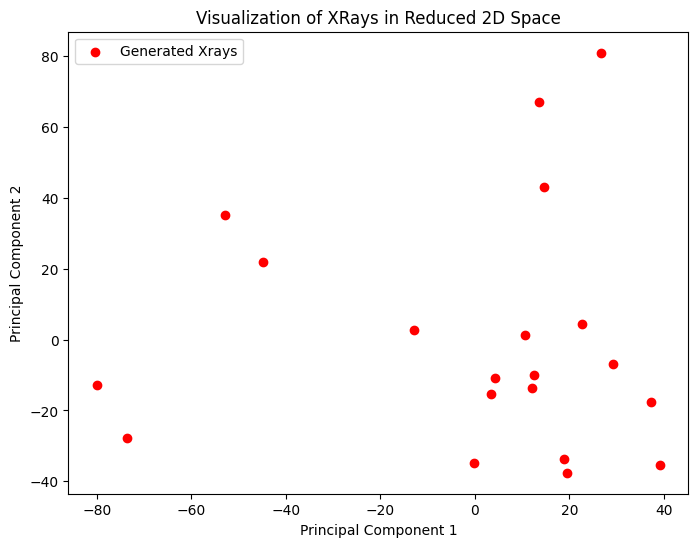

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Generate 20 new data points (rocks) using the GMM sample method
num_samples = 20
new_xray_pca = gmm.sample(num_samples)[0]  # We use the first element of the tuple returned by sample()

# Step 2: Inverse transform the generated samples from PCA space back to the original space
new_xray_original = pca.inverse_transform(new_xray_pca)

# Step 3: Reduce dimensionality to 2D for visualization if necessary
if new_xray_original.shape[1] > 3:
    pca_for_visualization = PCA(n_components=2)
    new_xray_reduced = pca_for_visualization.fit_transform(new_xray_original)
else:
    new_xray_reduced = new_xray_original  # No need to reduce if it's already 2D or 3D

# Step 4: Visualize the generated rocks in the reduced 2D space
plt.figure(figsize=(8, 6))
plt.scatter(new_xray_reduced[:, 0], new_xray_reduced[:, 1], color='red', label='Generated Xrays')
plt.title('Visualization of XRays in Reduced 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Found categories: ['NORMAL', 'PNEUMONIA', 'COVID19']


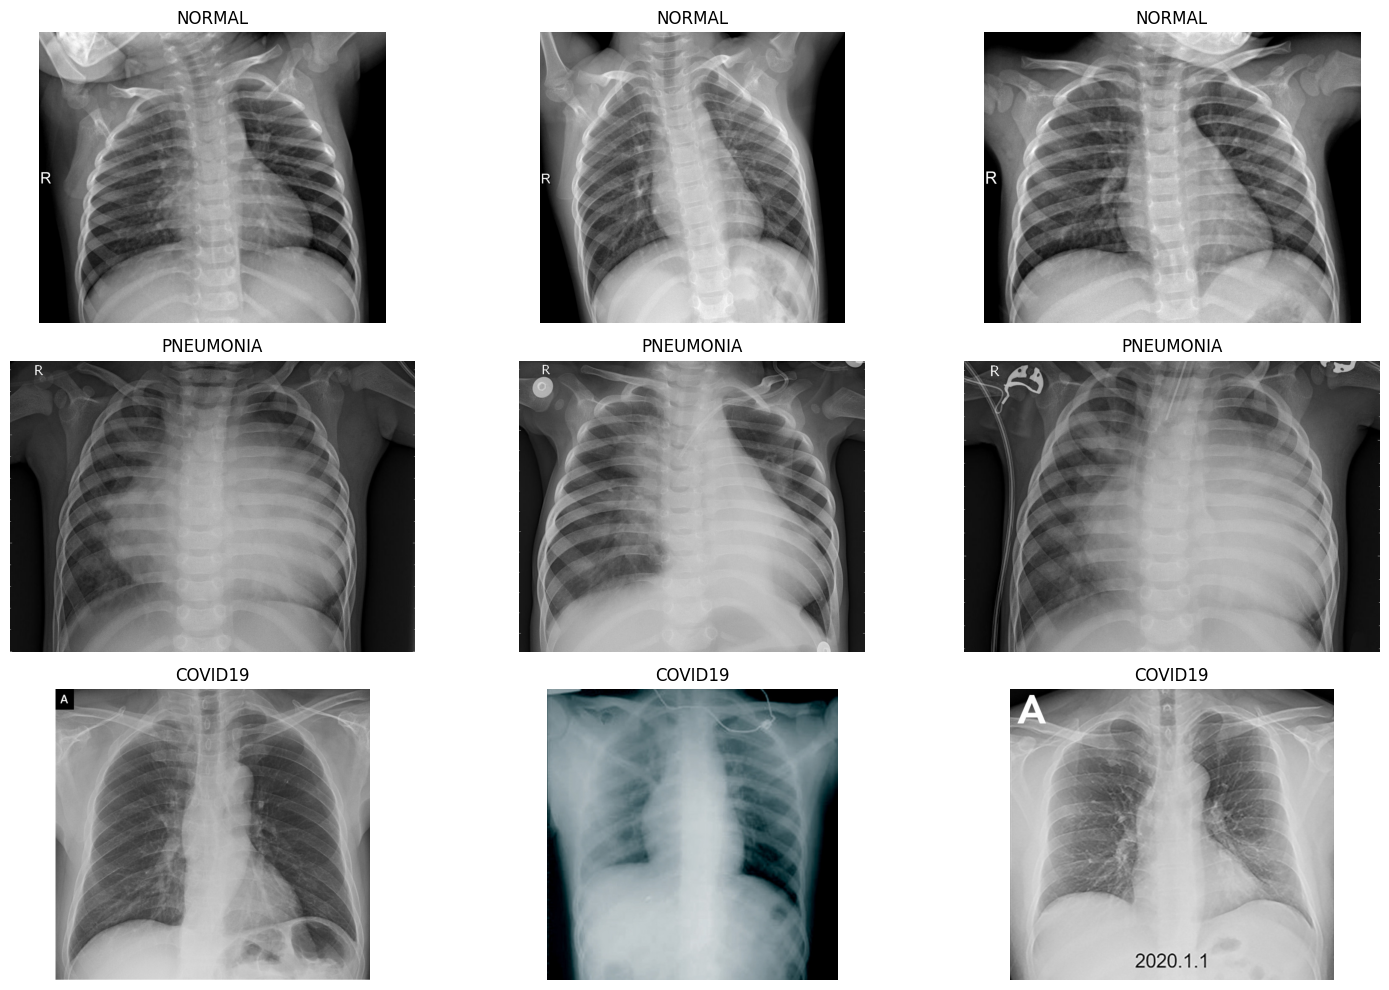

In [26]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


# Step 1: Inspect and list all subdirectories (categories)
categories = [d for d in os.listdir(VALIDATION_DIR) if os.path.isdir(os.path.join(VALIDATION_DIR, d))]
print(f"Found categories: {categories}")

if not categories:
    raise FileNotFoundError("No subdirectories (categories) found in the root directory.")

# Step 2: Collect random image paths from each category
image_files = []
for category in categories:
    category_path = os.path.join(VALIDATION_DIR, category)
    category_images = [
        os.path.join(category_path, f)
        for f in os.listdir(category_path)
        if f.lower().endswith(('png', 'jpg', 'jpeg'))
    ]

    # Randomly sample up to 3 images (if fewer than 3, take all)
    random_images = random.sample(category_images, min(3, len(category_images)))
    image_files.extend(random_images)

# Verify that there are images
if not image_files:
    raise FileNotFoundError("No images found in any of the category folders.")

# Step 3: Display the random images from all categories
num_images_to_display = len(image_files)  # Total number of images to display

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_files):
    img = Image.open(img_path)

    # Display the image in a grid
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Show the category name (parent folder of the image)
    plt.title(os.path.basename(os.path.dirname(img_path)))

plt.tight_layout()
plt.show()


In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings('ignore')

train_path= TRAINING_DIR
test_path= VALIDATION_DIR

image_classes=os.listdir(train_path)
print(image_classes)

data_generator=ImageDataGenerator(rescale=1/255)

train_data = data_generator.flow_from_directory(
  train_path,  
    target_size=(224,224),
    batch_size= 32  
)
test_data = data_generator.flow_from_directory(
  test_path, 
    target_size=(224,224),  
    batch_size= 32  
)
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(filters=32, kernel_size=3, padding='same',
                 activation='relu', input_shape=[224, 224, 3]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())

# Add flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output layer
model.add(Dense(3, activation='softmax'))

# Get model parameters
total_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
bias_params = np.sum([np.prod(v.shape) for v in model.trainable_weights if len(v.shape) == 1])




['NORMAL', 'PNEUMONIA', 'COVID19']
Found 903 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


In [28]:
model.compile(
              optimizer= Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'] # catgorical,
             )

In [29]:
model_history=model.fit(train_data,
                       epochs=20,
                       validation_data=test_data
                        # we have small data so we will take the test data to validate from it to train and test at the same time
                       )

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.5417 - loss: 0.9246 - val_accuracy: 0.7593 - val_loss: 0.5477
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 712ms/step - accuracy: 0.8318 - loss: 0.4766 - val_accuracy: 0.8025 - val_loss: 0.4311
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 751ms/step - accuracy: 0.8954 - loss: 0.3181 - val_accuracy: 0.8642 - val_loss: 0.2961
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 820ms/step - accuracy: 0.9313 - loss: 0.1901 - val_accuracy: 0.9383 - val_loss: 0.2041
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 786ms/step - accuracy: 0.9488 - loss: 0.1645 - val_accuracy: 0.9475 - val_loss: 0.1820
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 865ms/step - accuracy: 0.9392 - loss: 0.1568 - val_accuracy: 0.9475 - val_loss: 0.1733
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 718ms/step - accuracy: 0.9644 - loss: 0.0988 - val_accuracy: 0.9383 - val_loss: 0.2164
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 684ms/step - accuracy: 0.9677 - loss: 0.0844 - val_accura

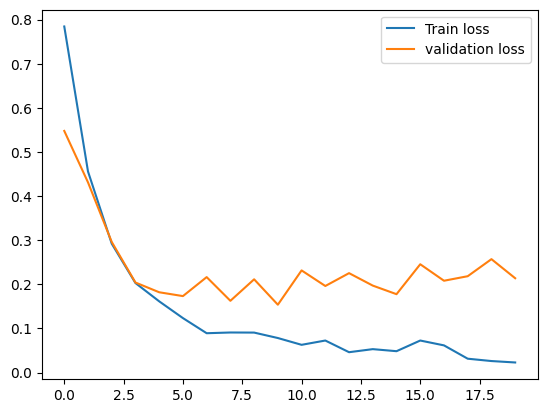

In [30]:
plt.plot(model_history.history['loss'],label='Train loss')
plt.plot(model_history.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

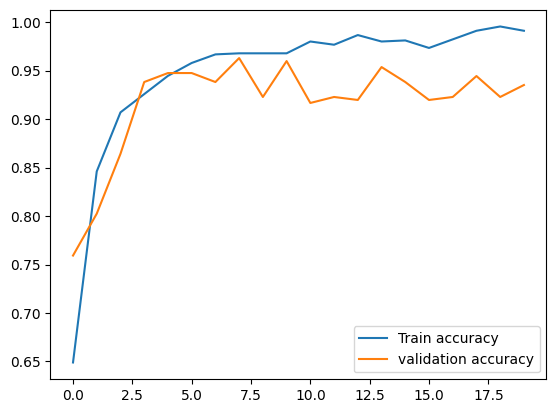

In [31]:
plt.plot(model_history.history['accuracy'],label='Train accuracy')
plt.plot(model_history.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

### Inference from the Training and Validation Metrics

#### 1. **Loss Curves**:
   - **Observation**:
     - Both training and validation loss decrease rapidly during the initial epochs, indicating that the model is learning effectively.
     - The training loss continues to decrease steadily, reaching very low values.
     - The validation loss decreases up to a point but then fluctuates and increases slightly toward the later epochs.

   - **Conclusion**:
     - **Early Training Phase**: The model fits both training and validation data well.
     - **Later Epochs**: The divergence between training and validation loss indicates slight **overfitting**. While the model continues to improve on the training set, its performance on unseen data (validation set) plateaus and slightly worsens.

---

#### 2. **Accuracy Curves**:
   - **Observation**:
     - Training accuracy increases steadily and reaches very high levels (~99%).
     - Validation accuracy follows a similar trend initially, peaking around 95%, but fluctuates after certain epochs.
   
   - **Conclusion**:
     - The high training accuracy shows the model has successfully learned the training data.
     - The fluctuations and slight decrease in validation accuracy in later epochs suggest potential overfitting.

---

### General Insights:
   - **Model Performance**: The model demonstrates good learning capability, achieving high accuracy on both training and validation data.
   - **Overfitting**: Signs of overfitting appear after around the 10th epoch, as evidenced by the divergence between training and validation losses and the fluctuations in validation accuracy.
   

In [40]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,818,475 (148.08 MB)

 Trainable params: 12,939,491 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,878,984 (98.72 MB)

In [39]:
print(f"Bias Parameters: {bias_params}")

Bias Parameters: 363
